# Demo

---

In this demo file we show:

1. How to generate a toy dataset using the concordant and discordant profiles we have identified.
2. How we run our clustering analysis, using the toy dataset.
3. How to map new individuals to the profiles we identified, again using the toy dataset.

---

## 1. Libraries

In [1]:
library(tibble)
library(dplyr, warn.conflicts = FALSE)
library(tidyr)
library(purrr)
library(ggplot2)
library(MGMM)
library(Matrix, warn.conflicts = FALSE)
library(uwot)
library(igraph, warn.conflicts = FALSE)
library(mvtnorm)
library(ggraph)
library(patchwork)
library(ggh4x)
library(broom)

In [2]:
options(repr.plot.res = 300)

---

## 2. Concordant and discordant profile parameters

In [3]:
load("../data/validclusmod.RData")

In [4]:
print(validclusmod)

# A tibble: 2 × 3
  sex    residmod          clusmod         
  <chr>  <list>            <list>          
1 Female <tibble [10 × 6]> <tibble [6 × 4]>
2 Male   <tibble [10 × 6]> <tibble [5 × 4]>


This table contains, for both sexes:

- The column `residmod`, which contains the observed relationship between BMI and each biomarker.
- The column `clusmod`, which contains the parameters of concordant and discordant profiles.

## 3. Dataset simulation

In this section we will generate a random dataset with:
- Normal distribution of BMI around 28 kg/m2, with a SD of 3.
- Uniform distribution of age from 45 to 75 years.
- Around 10% of individuals currently smoking.
- Biomarkers following the distribution of concordant and discordant profiles we identified.

First we generate the basic variables BMI, age and smoking:

In [5]:
initN <- 1e5

In [6]:
rgendat <- tibble(
  sex = c("Female", "Male")
) %>%
  mutate(
    basictab = map(
      sex,
      ~tibble(
        bmi = rnorm(n = initN, mean = 28, sd = 3),
        age = runif(n = initN, min = 45, max = 75),
        smoking = rbinom(n = initN, size = 1, prob = .1)
      )
    )
  )

This is a nested table that looks like this:

In [7]:
print(rgendat)

# A tibble: 2 × 2
  sex    basictab              
  <chr>  <list>                
1 Female <tibble [100,000 × 3]>
2 Male   <tibble [100,000 × 3]>


In each row of `basictab`:

In [8]:
with(rgendat, head(basictab[[1]]))

bmi,age,smoking
<dbl>,<dbl>,<int>
27.70816,56.91827,0
26.82174,50.19867,0
27.71448,70.17953,0
30.76153,60.73601,0
24.42399,69.39991,0
28.73121,73.37352,1


Calculating predicted values of biomarkers based on the simulated basic values and the observed BMI-biomarker relationships:

In [9]:
rgendat <- rgendat %>%
  mutate(
    predtab = map2(
      sex, basictab,
      ~{
        MOD <- validclusmod %>%
          filter(sex == .x) %>%
          pluck("residmod", 1)
        RES <- apply(
          X = MOD[,c("Intercept", "bmi", "age", "smoking")], 
          MARGIN = 1,
          FUN = function(COEFS){
            cbind(1, as.matrix(.y)) %*% COEFS
          }
        )
        colnames(RES) <- MOD$Biomarker
        return(RES)
      }
    )
  )

How do these predicted values look like:

In [10]:
with(rgendat, head(predtab[[1]]))

whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
0.8198048,137.6060,81.87117,20.29054,64.51080,2.598334,1.602137,1.536963,3.663614,4.978135
0.8054797,130.9918,80.99627,19.17299,63.73316,2.243569,1.602158,1.379440,3.525289,4.880344
0.8372164,149.6207,82.62251,21.66635,65.65388,2.859449,1.650762,1.762184,3.920147,5.147963
0.8438285,142.8828,83.79494,22.13912,65.52544,3.442100,1.530937,1.751754,3.766273,5.067582
0.8156953,146.9543,80.73739,20.01940,64.84752,2.015417,1.739764,1.587267,3.874007,5.094254
0.8687748,150.6576,82.49752,21.52066,64.87040,3.913820,1.518929,2.118777,4.051877,5.150959


Now generating random distribution of BMI-biomarker discordances, based on the concordant-discordant profile models:

In [11]:
rgendat <- rgendat %>%
  mutate(
    residtab = map(
      sex,
      ~{
        CLUSMOD <- validclusmod %>%
          filter(sex == .x) %>%
          pluck("clusmod", 1)
        rd <- rGMM(
          n = initN, 
          d = length(CLUSMOD$validclus_centers[[1]]), 
          k = nrow(CLUSMOD), 
          pi = CLUSMOD$validclus_weights, 
          means = CLUSMOD$validclus_centers, 
          covs = CLUSMOD$validclus_covmats
        )
        rownames(rd) <- NULL
        colnames(rd) <- names(CLUSMOD$validclus_centers[[1]])
        return(rd)
      }
    )
  )

In [12]:
with(rgendat, head(residtab[[1]]))

whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
-0.30646747,0.9345672,-1.3958615,0.83477775,1.0570408,-0.47549875,0.3010441,0.7817387,1.3839054,0.9974250
0.08326406,-0.7723608,0.1701264,0.76532372,-0.3227839,0.23565513,0.5314766,-0.1854584,0.8490224,1.3517896
0.62328603,-0.9882095,2.9697278,-0.02219151,0.8936103,-0.52662460,1.6685076,-0.7141284,-0.1938454,-0.5415075
0.38362567,0.6304949,0.2186067,0.40281455,0.6701607,2.25055370,-1.1385117,1.0172021,1.4629047,0.9546185
-0.29613342,1.0242435,0.9074591,0.50869173,-0.9342053,1.14927249,-1.7871951,0.2946089,-1.2836230,-0.1489540
0.51963796,0.9841561,0.2785033,1.00368209,0.2501885,-0.01706322,-0.2471124,-0.5698752,0.6075101,-0.4768790


These discordances are scaled to unit SD. To return the observed biomarker values, each column needs to be unscaled:

In [13]:
rgendat <- rgendat %>%
  mutate(
    bmtab = pmap(
      list(sex, residtab, predtab),
      function(SEX, RESID, PRED){
        MOD <- validclusmod %>%
          filter(sex == SEX) %>%
          pluck("residmod", 1)
        BM <- MOD$Biomarker
        RESID <- RESID[,BM]
        URESID <- RESID %*% diag(MOD$SDRes)
        return(PRED + URESID)
      }
    )
  )

These are the resulting biomarker values:

In [14]:
with(rgendat, head(bmtab[[1]]))

whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
0.8011938,154.2041,68.63275,28.09258,75.76349,1.216631,1.707577,2.119387,4.853312,5.560820
0.8105361,117.2745,82.60976,26.32591,60.29698,2.928335,1.788306,1.241266,4.255166,5.670044
0.8750669,132.0699,110.78757,21.45894,75.16678,1.329185,2.235152,1.230132,3.753504,4.831621
0.8671251,154.0805,85.86822,25.90393,72.65961,9.981753,1.132176,2.509608,5.023884,5.625259
0.7977119,165.1451,89.34378,24.77377,54.90247,5.354970,1.113804,1.806762,2.770518,5.007236
0.9003310,168.1364,85.13886,30.90133,67.53377,3.864238,1.432379,1.694198,4.574133,4.872371


To trim these values, we can set boundaries based on the observed limits:

In [15]:
bm_caps <- rbind(
  whr = c(0.5, 1.5),
  sbp = c(70, 230),
  dbp = c(50, 130),
  alt = c(3, 100),
  scr = c(10, 160),
  crp = c(0.05, 25),
  hdl = c(0.2, 3.5),
  tg = c(0.2, 6.5),
  ldl = c(0.2, 7.5),
  fg = c(1, 10)
)

Indexing individuals with simulated values within these limits:

In [16]:
rgendat <- rgendat %>%
  mutate(
    idtoinc = map(
      bmtab,
      ~{
        IDX <- sapply(
          colnames(.x),
          function(VAR){
            Xc <- .x[,VAR]
            LIMS <- bm_caps[VAR,]
            Xc < LIMS[1] | Xc > LIMS[2]
          }
        )
        rowSums(IDX) == 0
      }
    )
  )

From these, we can sample a subset of 10,000 individuals with all biomarkers available to obtain our final simulated dataset:

In [17]:
rgendatf <- rgendat %>%
  mutate(
    idtoinc = map(
      idtoinc,
      ~sample(which(.x), size = 1e4)
    )
  ) %>%
  transmute(
    sex,
    finaltab = pmap(
      list(basictab, bmtab, idtoinc),
      function(T1, T2, IDX){
        bind_cols(T1[IDX,], T2[IDX,])
      }
    )
  ) %>%
  unnest(finaltab) %>%
  mutate(eid = row_number(), .before = 1)
head(rgendatf)

eid,sex,bmi,age,smoking,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female,27.89703,71.92897,0,1.0277422,116.3553,93.04166,26.200749,55.42433,9.0064259,0.9674362,1.9403482,2.795291,5.040744
2,Female,34.31434,59.09310,0,0.8449312,147.4256,89.54938,20.770402,66.84733,12.6495473,1.6347672,2.0665351,3.950511,4.528436
3,Female,32.85436,66.75912,1,0.9350050,179.2411,81.99926,9.596497,60.92779,6.6441243,1.2881896,2.8242896,3.859056,5.889402
4,Female,28.34635,60.91207,0,0.8594111,122.3434,83.67976,23.067301,68.89955,0.1610696,1.9187024,1.2410483,3.913147,5.707510
5,Female,32.75755,64.59296,0,0.8623249,131.1127,71.55395,42.814032,52.69719,6.2017067,1.3025867,2.4094467,3.138702,5.154231
6,Female,30.36313,51.89503,0,0.9123512,136.2242,70.81686,22.802565,68.82677,3.1809497,1.8054434,0.6440901,3.197167,5.348512


We can inspect the distribution of the continuous variables:

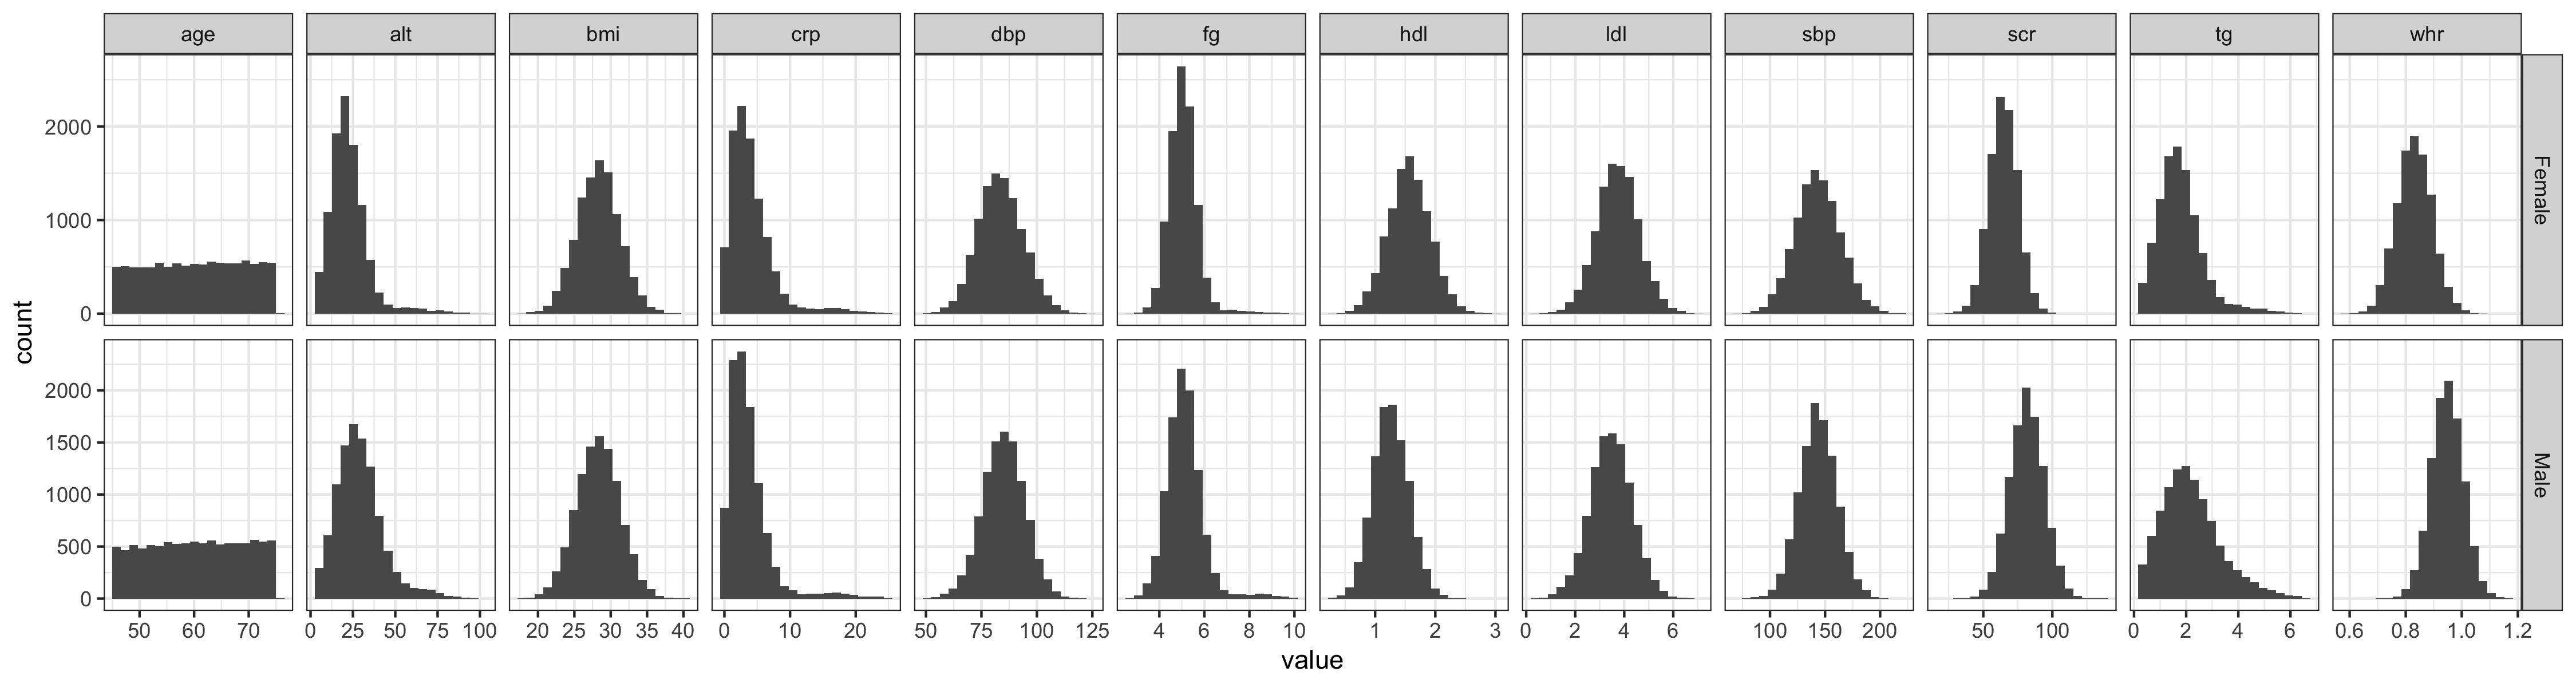

In [18]:
options(repr.plot.width = 15, repr.plot.height = 4)
rgendatf %>%
  select(-smoking) %>%
  pivot_longer(-c(eid, sex)) %>%
  ggplot(aes(value)) +
  geom_histogram(bins = 20) +
  facet_grid(sex ~ name, scales = "free") +
  theme_bw()

## 4. How we run our clustering analysis

In this section we will show how we run our clustering analysis using the simulated dataset we generated above.

We first load the functions that we used:

In [19]:
source("../scripts/01_cross_sectional_FX.R")

First we stratify data by sex:

In [20]:
strat_dat <- split(rgendatf, ~sex)

Then estimate BMI-biomarker associations:

In [21]:
mods <- get_bmimods(strat_dat)

Then estimate the BMI-biomarker discordances:

In [22]:
residtab <- get_residtabs(strat_dat, mods)

Then we can run the cluster analysis:

In [23]:
cluster_results <- get_cluster_results(residtab)

Starting analysis for the Female subset:

	1. Setting parameters...

	2. Running UMAP...

	3. Extracting graph...

	4. Initializing graph clustering using the leading eigen vector method...

	5. Optimizing graph clustering using the Leiden algorithm...

	   10 clusters found. Modularity = 0.62.

	6. Extracting cluster membership...

	7. Calculating eigen centrality in clusters...

	8. Calculating Gaussian subdistributions weighted by eigen centralities...

	9. Adding central/concordant subdistribution...

	10. Fitting a mixture of Gaussians with subdistributions found...

		Convergence reached in 43 iterations.

	11. Organizing results...

Done!

Starting analysis for the Male subset:

	1. Setting parameters...

	2. Running UMAP...

	3. Extracting graph...

	4. Initializing graph clustering using the leading eigen vector method...

	5. Optimizing graph clustering using the Leiden algorithm...

	   10 clusters found. Modularity = 0.62.

	6. Extracting cluster membership...

	7. Calculat

To inspect the results:

- We can check the 2-dimensional UMAP projection, which should generate subgroups deviating from the concordant profile, located in the center of the projection:

In [24]:
umap_models <- get_umap_mod(cluster_results)

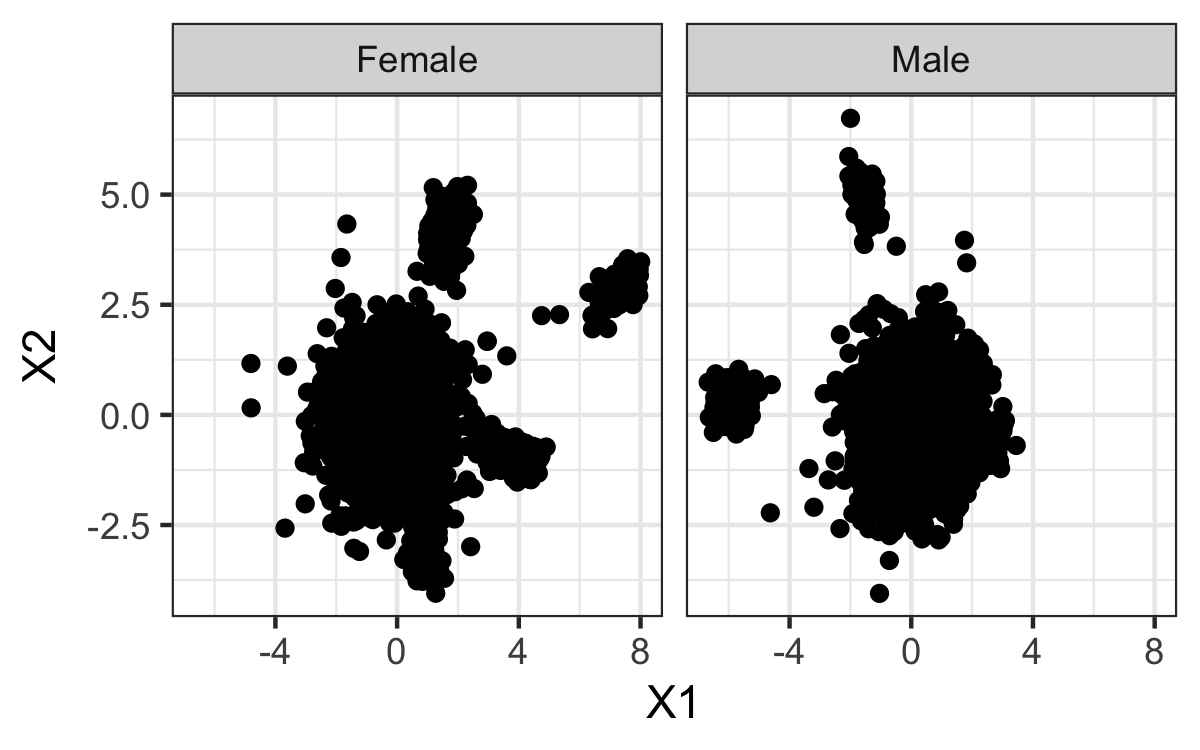

In [25]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
umap_models %>% 
  map("embedding") %>%
  map(data.frame) %>%
  bind_rows(.id = "sex") %>%
  ggplot(aes(X1, X2)) +
  geom_point() +
  facet_wrap(~sex) +
  theme_bw()

- We can check the centers of the clusters that were found, some of which should map to our clusters:

In [26]:
clustersummary <- get_clustersummary(cluster_results)

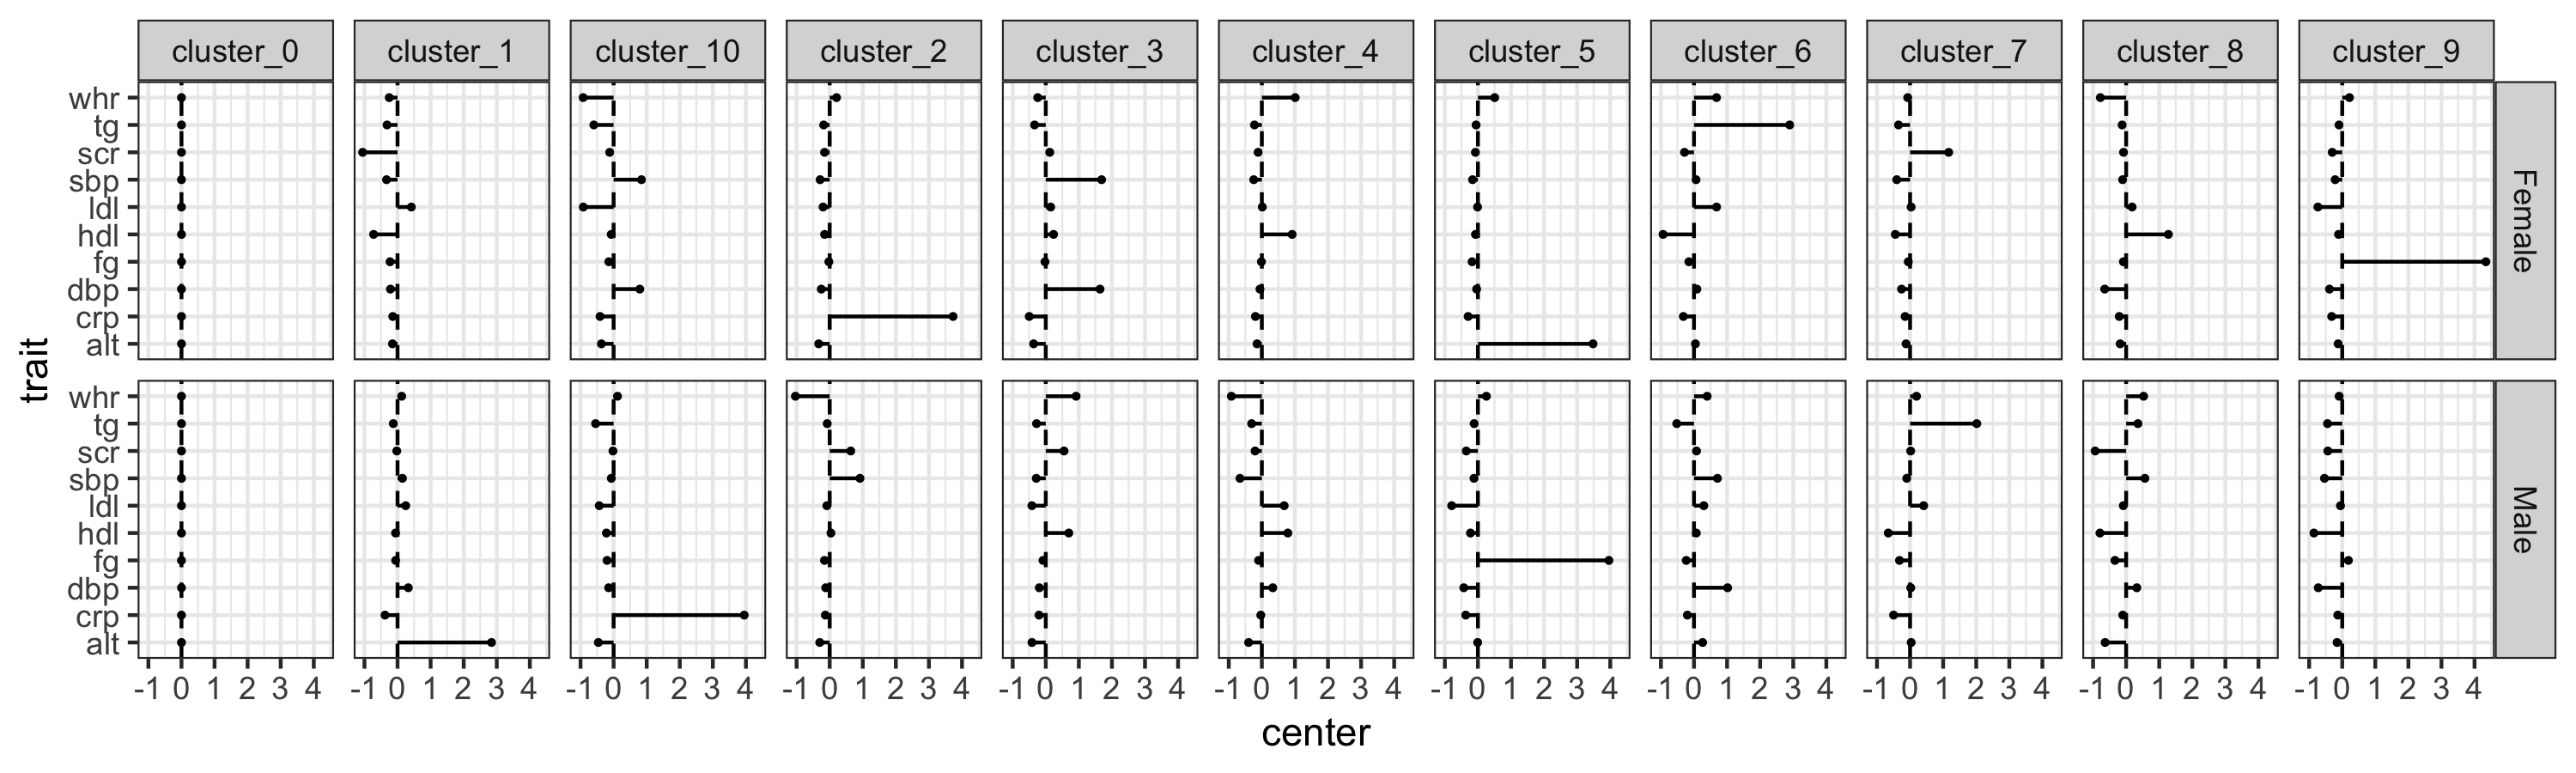

In [27]:
options(repr.plot.width = 10, repr.plot.height = 3)
clustersummary %>%
  ggplot(aes(center, trait)) +
  geom_vline(aes(xintercept = 0), lty = "dashed") +
  geom_linerange(aes(xmin = 0, xmax = center)) +
  geom_point(size = .5) +
  facet_grid(sex ~ cluster) +
  theme_bw()

## 5. How we run our profile validation

To show how we run our cluster validation, we can reproduce the scenario that we had were there was a discovery cohort and 3 other validation cohorts.

Here we use the same functions as before to simulate 3 other validation cohorts:

In [28]:
clusvaldf <- expand_grid(
  sex = c("Female", "Male"),
  cohort = paste("cohort", 1:3, sep = "_")
) %>%
  mutate(
    bmtab = map(
      sex,
      ~{
        RMOD <- validclusmod %>%
          filter(sex == .x) %>%
          pluck("residmod", 1)
        CLUSMOD <- validclusmod %>%
          filter(sex == .x) %>%
          pluck("clusmod", 1)
        BASICTAB <- cbind(
          bmi = rnorm(n = initN, mean = 28, sd = 3),
          age = runif(n = initN, min = 45, max = 75),
          smoking = rbinom(n = initN, size = 1, prob = .1)
        )
        PREDTAB <- apply(
          X = RMOD[,c("Intercept", "bmi", "age", "smoking")], 
          MARGIN = 1,
          FUN = function(COEFS){
            cbind(1, as.matrix(BASICTAB)) %*% COEFS
          }
        )
        colnames(PREDTAB) <- RMOD$Biomarker
        RESID <- rGMM(
          n = initN, 
          d = length(CLUSMOD$validclus_centers[[1]]), 
          k = nrow(CLUSMOD), 
          pi = CLUSMOD$validclus_weights, 
          means = CLUSMOD$validclus_centers, 
          covs = CLUSMOD$validclus_covmats
        )
        rownames(RESID) <- NULL
        colnames(RESID) <- names(CLUSMOD$validclus_centers[[1]])
        RESID <- RESID[,RMOD$Biomarker]
        URESID <- RESID %*% diag(RMOD$SDRes)
        BMTAB <- PREDTAB + URESID
        IDX <- sapply(
          RMOD$Biomarker,
          function(VAR){
            Xc <- BMTAB[,VAR]
            LIMS <- bm_caps[VAR,]
            Xc < LIMS[1] | Xc > LIMS[2]
          }
        )
        IDX <- sample(which(rowSums(IDX) == 0), size = 1e4)
        data.frame(eid = 1:1e4, sex = .x, BASICTAB[IDX,], BMTAB[IDX,])
      }
    )
  ) %>%
  select(-sex) %>%
  nest(D = -cohort) %>%
  mutate(D = map(D, ~bind_rows(.x$bmtab)))

In [29]:
print(clusvaldf)

# A tibble: 3 × 2
  cohort   D                 
  <chr>    <list>            
1 cohort_1 <df [20,000 × 15]>
2 cohort_2 <df [20,000 × 15]>
3 cohort_3 <df [20,000 × 15]>


Again, each row of the `D` column in this table looks like this:

In [30]:
clusvaldf$D[[1]] %>% head

,eid,sex,bmi,age,smoking,whr,sbp,dbp,alt,scr,crp,hdl,tg,ldl,fg
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Female,26.53365,46.63144,0,0.8697243,121.6914,75.14889,7.414250,47.61178,3.836054,1.1666653,1.2803607,3.855053,4.981174
2,2,Female,32.41109,49.98711,0,0.9559413,136.9723,89.69650,32.519129,67.36089,1.315933,0.5604112,1.2490035,1.396586,4.859296
3,3,Female,26.15270,69.36169,0,0.7566019,151.8381,94.24083,8.704590,62.73820,4.082176,0.7752066,2.0351829,3.887410,5.350738
4,4,Female,30.18358,49.06748,0,0.8460509,157.6840,96.98819,44.358335,47.68408,5.848084,1.9892194,0.8790972,3.828788,4.695386
5,5,Female,28.99863,65.48730,0,0.8351517,137.0351,87.65829,16.626084,66.47373,6.261550,1.3580365,2.1741435,3.675995,5.054640
6,6,Female,25.45571,45.93058,0,0.7594599,131.0836,83.27773,6.958061,70.17206,18.916256,1.4617990,1.4306723,3.527176,5.093091


We can then run the same steps that we run in the 'discovery' cohort:

In [31]:
clusvaldf <- clusvaldf %>%
  mutate(
    cmod = map(
      D,
      ~{
        strat_datc <- split(.x, ~sex)
        modsc <- get_bmimods(strat_datc)
        modsumc <- get_bmicoefs(modsc)
        residtabc <- get_residtabs(strat_datc, modsc)
        clsresc <- suppressMessages(get_cluster_results(residtabc))
        return(list(modsumc = modsumc, clsresc = clsresc))
      }
    )
  )

In [32]:
print(clusvaldf)

# A tibble: 3 × 3
  cohort   D                  cmod            
  <chr>    <list>             <list>          
1 cohort_1 <df [20,000 × 15]> <named list [2]>
2 cohort_2 <df [20,000 × 15]> <named list [2]>
3 cohort_3 <df [20,000 × 15]> <named list [2]>


To validate the clusters that we found in the discovery cohort, we first took the data from the discovery cohort and mapped onto the clusters found in the validation cohorts, calculating the probabilities to belong to the clusters found in each cohort:

In [33]:
valclusprob <- clusvaldf %>%
  transmute(
    cohort,
    cvdat = map(
      cmod,
      function(CMOD){
        tibble(
          sex = c("Female", "Male")
        ) %>%
          mutate(
            NewData = map(
              sex, 
              function(SEX){ filter(rgendatf, sex == SEX) }
            ),
            coefd = map(
              sex,
              function(SEX){
                CMOD$modsumc %>%
                  filter(sex == SEX) %>%
                  transmute(
                    Biomarker, Estimate,
                    term = gsub("\\(|\\)", "", term)
                  ) %>%
                  pivot_wider(names_from = term, values_from = Estimate)
              }
            ),
            residmat = map2(
              NewData, coefd,
              function(NEWD, COEFD){
                BasDat <- NEWD %>%
                  transmute(Intercept = 1, bmi, age, smoking) %>%
                  as.matrix
                PredMat <- apply(
                  select(COEFD, Intercept, bmi, age, smoking),
                  1, function(CF){ BasDat %*% CF }
                )
                BM <- COEFD$Biomarker
                ObsMat <- as.matrix(NEWD[,BM])
                ResMat <- ObsMat - PredMat
                scale(ResMat)
              }
            ),
            probmat = map2(
              sex, residmat,
              function(SEX, RESIDMAT){
                CLUSDAT <- CMOD$clsresc[[SEX]][["clusters"]]
                X <- RESIDMAT[,BIOMARKERS]
                mus <- map(CLUSDAT, "center")
                mus <- map(mus, function(mu){ mu[BIOMARKERS] })
                covmats <- map(CLUSDAT, "cov")
                covmats <- map(covmats, function(covmat){ covmat[BIOMARKERS, BIOMARKERS] })
                wts <- map_dbl(CLUSDAT, "weight")
                pdfs <- mapply(function(mu, covmat){ mvtnorm::dmvnorm(X, mu, covmat) }, mus, covmats)
                L <- pdfs %*% diag(wts)
                colnames(L) <- colnames(pdfs)
                data.frame(L / rowSums(L))
              }
            )
          )
      }
    )
  ) %>%
  unnest(cvdat) %>%
  select(cohort, sex, probmat)

In [34]:
print(valclusprob)

# A tibble: 6 × 3
  cohort   sex    probmat           
  <chr>    <chr>  <list>            
1 cohort_1 Female <df [10,000 × 11]>
2 cohort_1 Male   <df [10,000 × 9]> 
3 cohort_2 Female <df [10,000 × 13]>
4 cohort_2 Male   <df [10,000 × 10]>
5 cohort_3 Female <df [10,000 × 11]>
6 cohort_3 Male   <df [10,000 × 9]> 


Now each element of the `probmat` column in the last table contains for each individual in the 'discovery' cohort their corresponding probabilities to belong to the clusters found in a validation cohort:

In [35]:
valclusprob$probmat[[1]] %>% head

,cluster_1,cluster_10,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.435911e-04,2.211047e-10,1.468327e-07,3.824834e-09,1.914786e-11,7.013723e-06,9.399189e-08,4.155142e-17,4.492545e-15,1.505426e-11,0.9992492
2,4.692833e-07,8.045115e-13,4.557026e-05,2.868283e-10,2.555142e-02,6.355965e-01,8.318264e-04,5.165844e-12,9.323382e-06,2.554222e-09,0.3379649
3,7.673769e-03,3.847080e-05,1.363674e-04,3.847213e-09,9.464355e-04,8.256983e-07,5.217160e-03,1.146254e-04,1.677126e-03,3.399801e-04,0.9838552
4,1.902336e-01,1.245366e-04,3.182137e-02,2.630013e-05,1.539789e-02,3.044579e-07,1.437321e-01,2.151121e-05,6.079839e-03,5.772495e-07,0.6125619
5,1.041888e-01,2.669835e-07,3.911664e-06,3.310431e-02,8.118980e-06,3.878233e-05,5.866552e-04,4.053846e-11,9.648511e-02,5.156074e-05,0.7655325
6,5.810302e-01,4.502124e-06,4.853997e-04,1.447452e-05,3.725240e-02,4.171394e-06,1.661538e-02,5.304918e-07,9.296197e-03,6.093191e-08,0.3552966


What we did was to take the individuals that were allocated to a certain cluster in the discovery model with high certainty (>80%) and then look at their median probability of allocation to all clusters from the models derived from the validation cohorts. We then only retained clusters in which individuals who were allocated with high certainty were also allocated with high certainty to a cluster in each of the validation cohorts:

In [36]:
valclusres <- valclusprob %>%
  mutate(
    refprobmat = map(sex, ~cluster_results[[.x]]$probs),
    probmat = map2(probmat, refprobmat, ~mutate(.x, eid = .y$eid)),
    refprobmat = map(refprobmat, pivot_longer, -eid, names_to = "refclus", values_to = "refprob"),
    probmat = map(probmat, pivot_longer, -eid, names_to = "othclus", values_to = "othprob"),
    refprobmat = map(refprobmat, filter, refprob >= .8),
    jointprob = map2(refprobmat, probmat, inner_join, by = "eid"),
    jointprob = map(jointprob, group_by, refclus, othclus),
    jointprob = map(jointprob, summarise, MedProb = median(othprob))
  ) %>%
  select(cohort, sex, jointprob) %>%
  unnest(jointprob) %>%
  filter(refclus != "cluster_0", MedProb >= .8)
head(valclusres)

cohort,sex,refclus,othclus,MedProb
<chr>,<chr>,<chr>,<chr>,<dbl>
cohort_1,Female,cluster_2,cluster_5,0.9968065
cohort_1,Female,cluster_3,cluster_7,0.9910776
cohort_1,Female,cluster_5,cluster_3,0.9957588
cohort_1,Female,cluster_6,cluster_9,0.9930780
cohort_1,Female,cluster_9,cluster_10,0.9993170
cohort_1,Male,cluster_1,cluster_5,0.9834704


To visualise this we drew a network were edges were drawn from a cluster in the discovery model to a cluster in one of the validation model if the condition specified above was met. Thus, we only retained clusters from the discovery model with three edges:

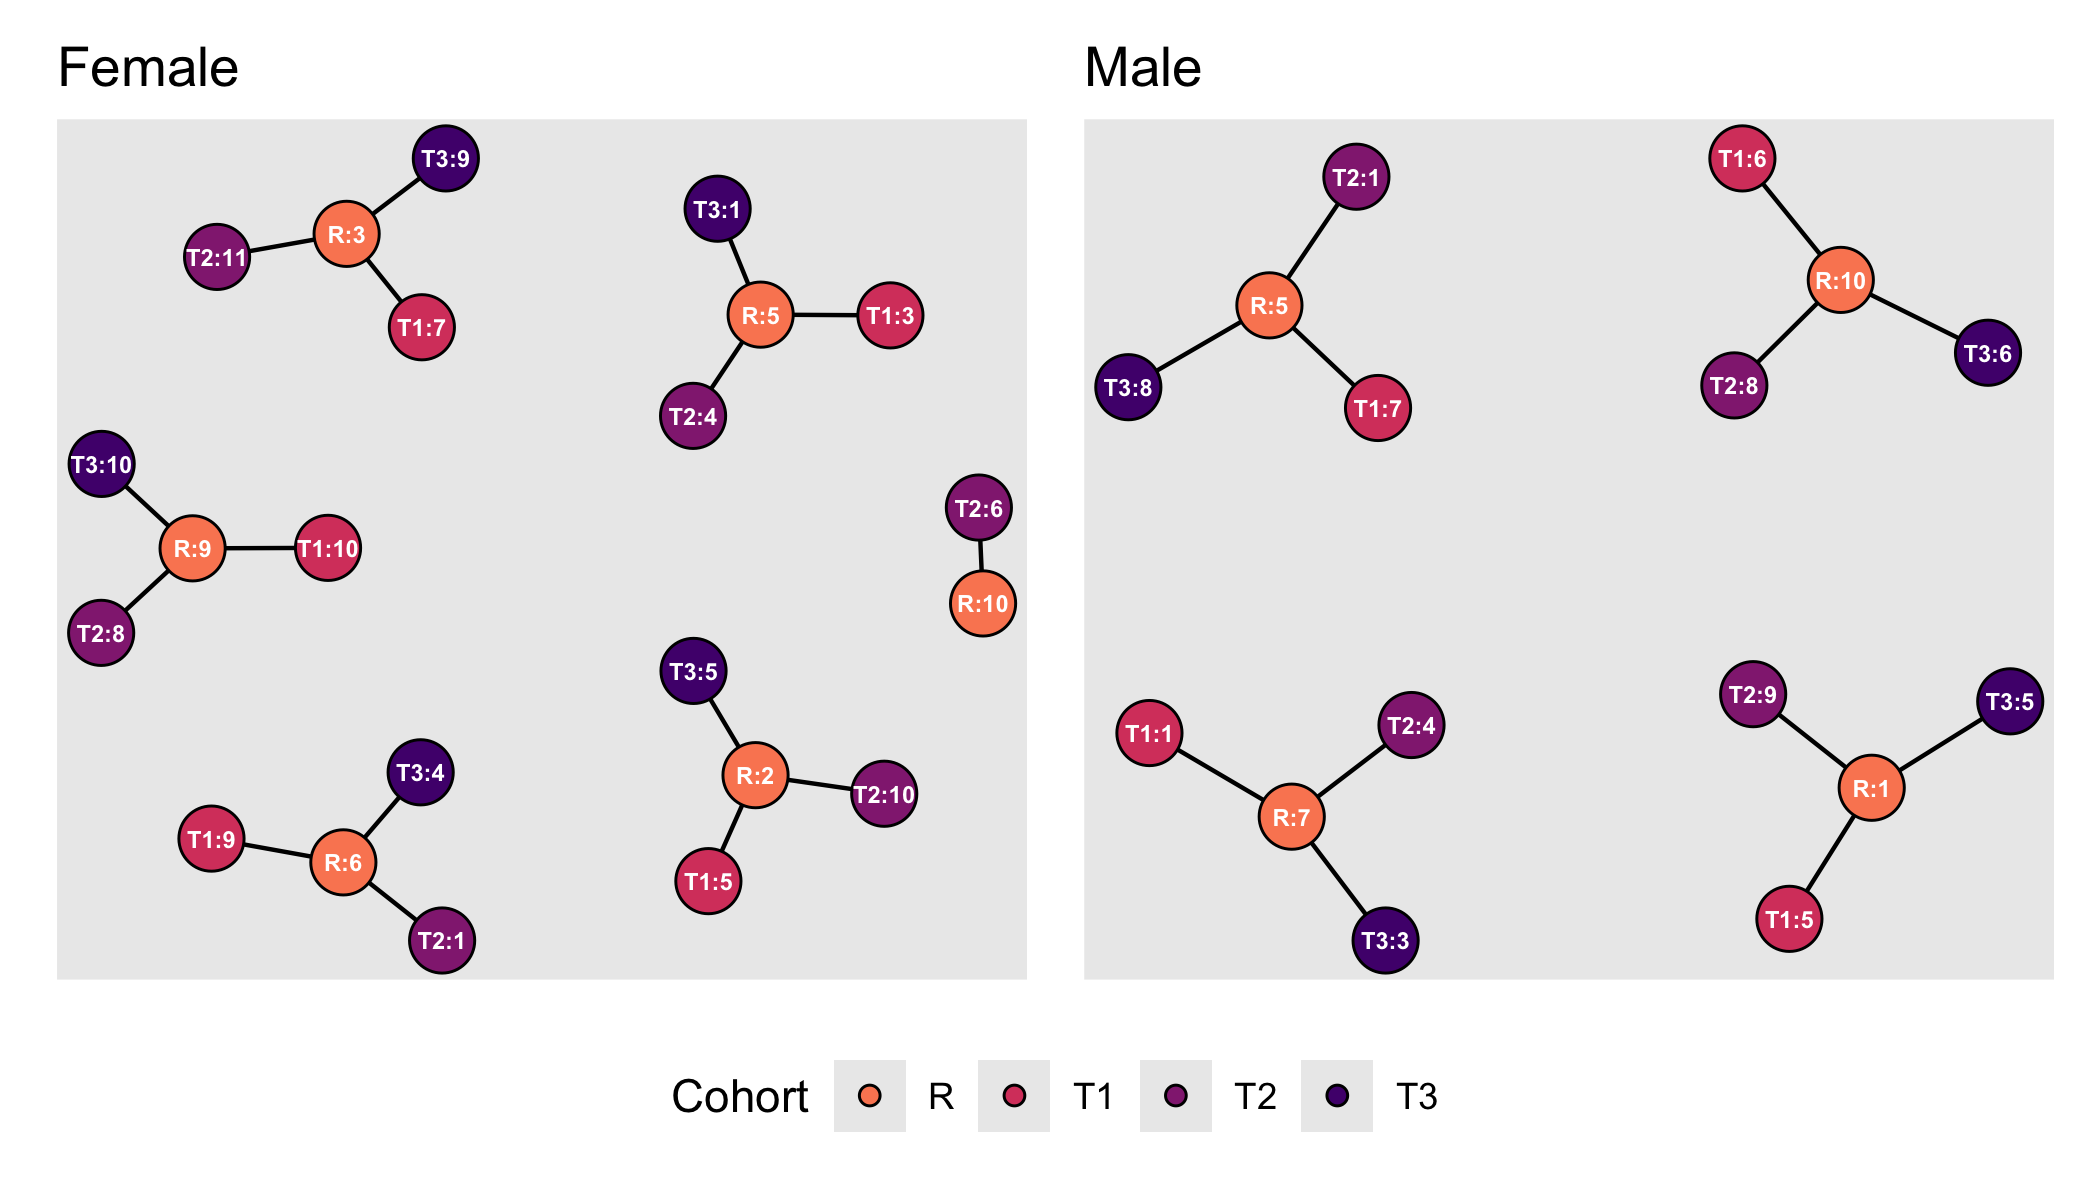

In [37]:
options(repr.plot.width = 7, repr.plot.height = 4)
valclusres %>%
    transmute(
        sex,
        from = gsub("cluster_", "R:", refclus),
        to = paste0(
          gsub("cohort_", "T", cohort), ":", 
          gsub("cluster_", "", othclus)
        )
    ) %>%
    nest(D = -sex) %>%
    mutate(
        net = map(D, ~graph_from_data_frame(.x, directed = FALSE)),
        netplot = map2(
            net, sex,
            ~.x %>%
                ggraph(layout = "igraph", algorithm = "nicely") +
                geom_edge_link() +
                geom_node_point(
                  aes(fill = gsub("^([A-Z][0-9]*):.+$", "\\1", name)), 
                  shape = 21, size = 7
                ) +
                scale_fill_viridis_d(
                    option = "A", begin = .25, end = .75, direction = -1,
                    #labels = c(R = "Reference", M = "TMS", R = "RS", G = "GHS"),
                    guide = guide_legend(override.aes = list(size = 2))
                ) +
                ggraph::geom_node_text(
                  aes(label = name), 
                  color = "white", 
                  fontface = "bold", size = 2
                ) +
                labs(title = .y, fill = "Cohort")
        )
    ) %>%
    pull(netplot) %>%
    wrap_plots(nrow = 1, guides = "collect") &
    theme(legend.position = "bottom")

We can also visualise the cluster centers to see if they actually align:

In [38]:
valcluspar <- valclusres %>%
  nest(Dval = -c(sex, refclus)) %>%
  filter(map_dbl(Dval, nrow) == 3) %>%
  mutate(
    Dval = map2(
      Dval, sex,
      function(VLD, SEX){
        VLD %>%
          transmute(
            cohort, cluster = othclus,
            centdat = map2(
              cohort, othclus,
              function(CRT, CLS){
                clusvaldf %>%
                  filter(cohort == CRT) %>%
                  pluck("cmod", 1, "clsresc", SEX, "clusters", CLS, "center") %>%
                  data.frame %>% rownames_to_column %>%
                  setNames(c("trait", "center"))
              }
            )
          ) %>%
          unnest(centdat)
      }
    ),
    Dref = map2(
      sex, refclus,
      ~clustersummary %>%
        filter(sex == .x, cluster == .y) %>%
        transmute(cohort = "R", cluster, trait, center)
    )
  ) %>%
  pivot_longer(-c(sex, refclus), names_to = NULL) %>%
  unnest(value) %>%
  mutate(cohort = gsub("cohort_", "T", cohort)) %>%
  select(-cluster)

In [39]:
head(valcluspar)

sex,refclus,cohort,trait,center
<chr>,<chr>,<chr>,<chr>,<dbl>
Female,cluster_2,T1,whr,-0.05330764
Female,cluster_2,T1,sbp,-0.26413134
Female,cluster_2,T1,dbp,-0.27917779
Female,cluster_2,T1,alt,-0.39771762
Female,cluster_2,T1,scr,-0.03263361
Female,cluster_2,T1,crp,3.70127296


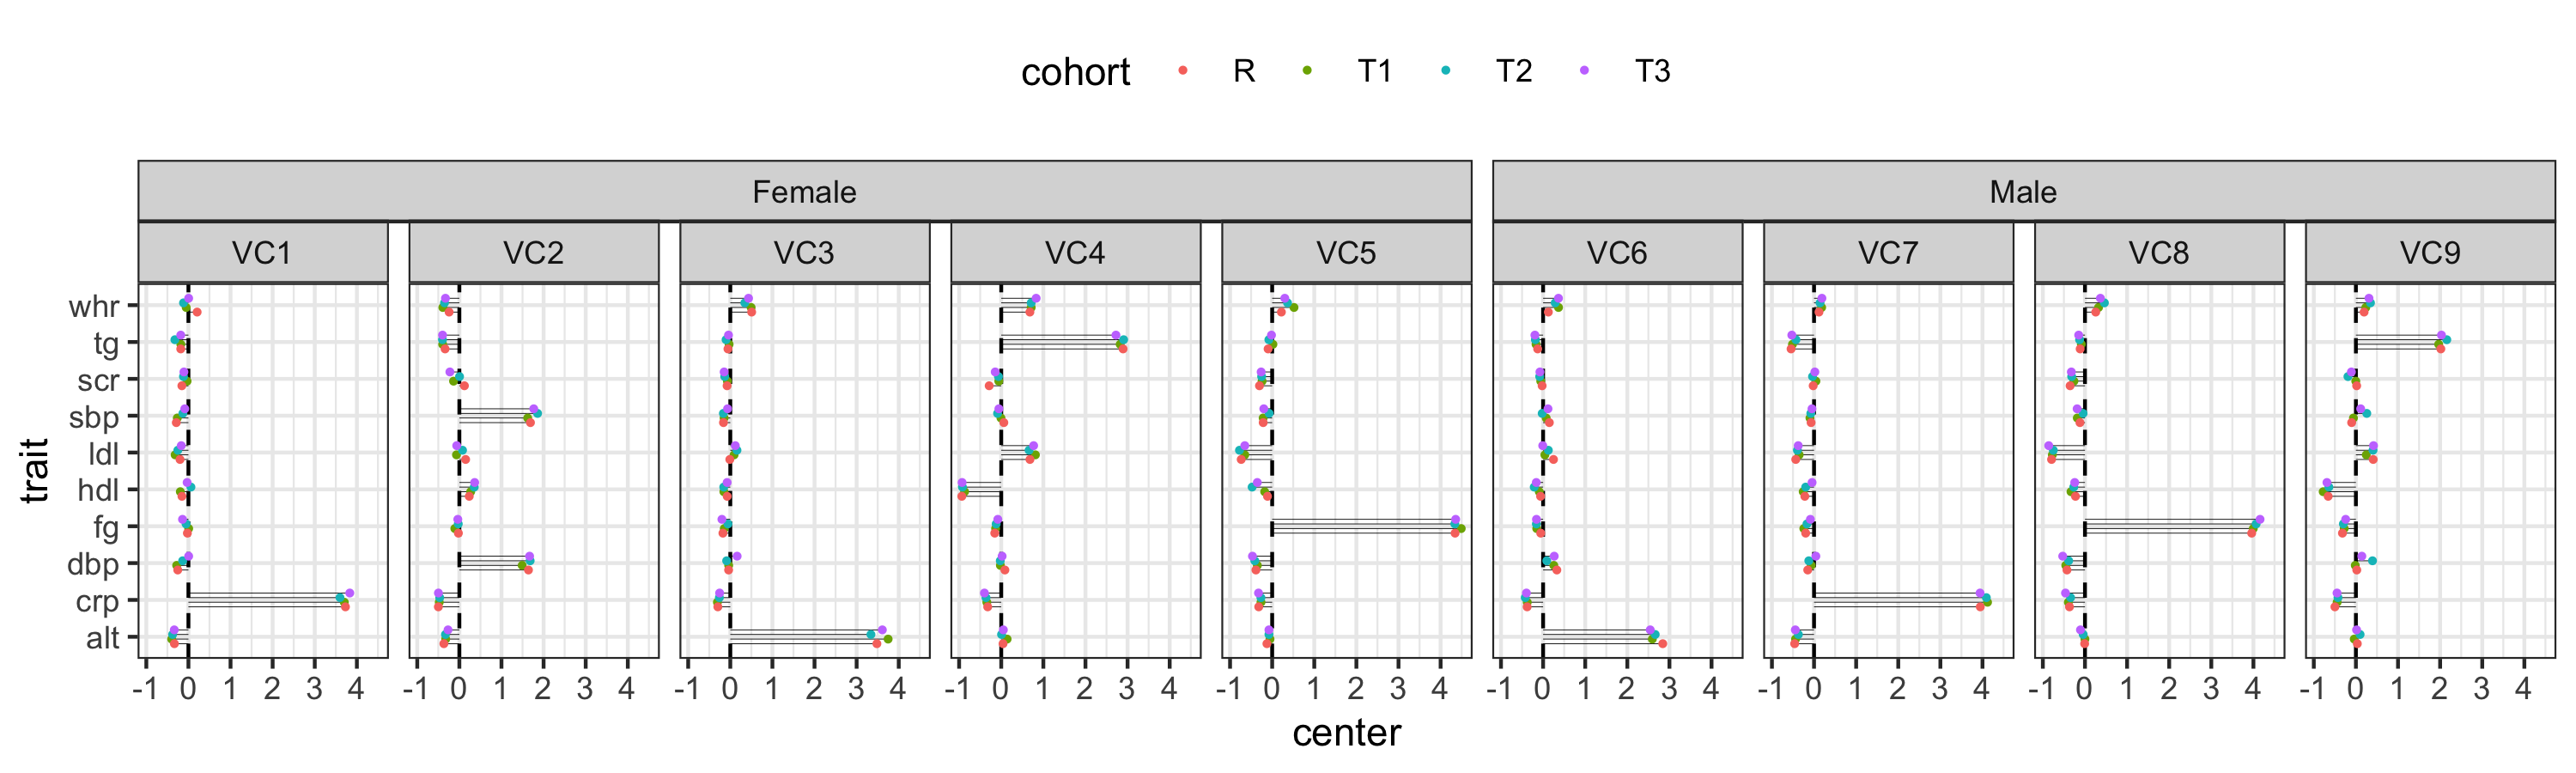

In [40]:
options(repr.plot.width = 10, repr.plot.height = 3)
valcluspar %>%
  group_by(sex, refclus) %>%
  mutate(clusid = paste0("VC", cur_group_id())) %>%
  ungroup %>%
  ggplot(aes(center, trait)) +
  geom_vline(aes(xintercept = 0), lty = "dashed", linewidth = .5) +
  geom_linerange(
    aes(xmin = 0, xmax = center, group = cohort),
    linewidth = .1, position = position_dodge(width = .5)
  ) +
  geom_point(
    aes(group = cohort, color = cohort),
    size = .5, position = position_dodge(width = .5)
  ) +
  facet_nested(~sex + clusid) +
  theme_bw() +
  theme(legend.position = "top")

## 6. How we tested the association of profiles to outcomes

To show how we tested the association of discordant profiles to outcomes, first let's simulate a binary outcome:

In [41]:
simulout <- rbinom(n = 1e4, size = 1, prob = .1)
head(simulout)
table(simulout)

[1] 0 0 1 1 0 0

simulout
   0    1 
8971 1029 

Adding this outcome to the profiles:

In [42]:
clusoutdat <- cluster_results %>%
  map("probs") %>%
  map(mutate, outcome = simulout)

The first, crude way to test profile-outcome associations was using a weighted approach, were all individuals contributed to cases and non-cases counts for all profiles, weighted by their profile probabilities:

In [43]:
clusoutdat_l <- clusoutdat %>%
  map(pivot_longer, -c(eid, outcome), names_to = "clusname", values_to = "clusprob")
map(clusoutdat_l, head)

eid,outcome,clusname,clusprob
<int>,<int>,<chr>,<dbl>
1,0,cluster_1,4.771815e-03
1,0,cluster_10,4.221833e-15
1,0,cluster_2,1.083041e-05
1,0,cluster_3,6.659364e-20
1,0,cluster_4,5.800180e-05
1,0,cluster_5,2.227388e-09
eid,outcome,clusname,clusprob
<int>,<int>,<chr>,<dbl>
10001,0,cluster_1,1.533620e-01


In [44]:
cluscountd <- clusoutdat_l %>%
  map(group_by, clusname) %>%
  map(summarise, Ncases = sum(clusprob * outcome), Total = sum(clusprob)) %>%
  bind_rows(.id = "sex") %>%
  mutate(
    Nnoncases = Total - Ncases,
    Prev = Ncases/Total
  )
cluscountd

sex,clusname,Ncases,Total,Nnoncases,Prev
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,cluster_0,457.95803,4455.7074,3997.7493,0.10278010
Female,cluster_1,74.19248,731.3022,657.1097,0.10145256
Female,cluster_10,39.38739,376.0475,336.6601,0.10474046
Female,cluster_2,44.71975,390.0108,345.2910,0.11466286
Female,cluster_3,74.23771,660.1763,585.9386,0.11245135
Female,cluster_4,73.65561,755.1720,681.5164,0.09753488
Female,cluster_5,46.27878,348.1612,301.8824,0.13292343
Female,cluster_6,52.50187,471.8056,419.3038,0.11127859
Female,cluster_7,100.02251,1045.7014,945.6789,0.09565112


These counts can then be used in binomial regressions to estimate crude odds ratios for each discordant profile relative to the concordant profile:

In [45]:
cluscountd %>%
  nest(D = -sex) %>%
  mutate(
    D = map(
      D, mutate, 
      clusname = relevel(factor(clusname), ref = "cluster_0"),
      across(c(Ncases, Nnoncases), round)
    ),
    D = map(D, ~glm(cbind(Ncases, Nnoncases) ~ clusname, data = .x, family = binomial)),
    D = map(D, tidy)
  ) %>%
  unnest(D) %>%
  mutate(term = gsub("clusname", "", term))

sex,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,(Intercept),-2.1666803309,0.04933083,-43.921421115,0.00000000
Female,cluster_1,-0.0169385943,0.13217078,-0.128156878,0.89802483
Female,cluster_10,0.0101590467,0.17618716,0.057660539,0.95401903
Female,cluster_2,0.1297984037,0.16599489,0.781942156,0.43424857
Female,cluster_3,0.0974256346,0.13286658,0.733259117,0.46340041
Female,cluster_4,-0.0542842337,0.13195954,-0.411370284,0.68080104
Female,cluster_5,0.2848947101,0.16578275,1.718482241,0.08570869
Female,cluster_6,0.0991013246,0.15390936,0.643894080,0.51964412
Female,cluster_7,-0.0803920521,0.11614910,-0.692145282,0.48884610


The second, more flexible option that allow adjustments is using the additive log ratio transformation of concordant and discordant profile probabilities:

In [46]:
clusoutdat_alr <- clusoutdat %>%
  map(
    transmute,
    outcome,
    across(
      starts_with("cluster"), 
      ~{
        RES <- .x
        RES <- ifelse(RES < 1e-15, 1e-15, RES)
        RES <- ifelse(RES > (1 - 1e-15), (1 - 1e-15), RES)
        log(RES/cluster_0)
      },
      .names = "alr{.col}"
    )
  ) %>%
  map(select, -alrcluster_0)
map(clusoutdat_alr, head)

,outcome,alrcluster_1,alrcluster_10,alrcluster_2,alrcluster_3,alrcluster_4,alrcluster_5,alrcluster_6,alrcluster_7,alrcluster_8,alrcluster_9
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-5.339990,-33.09347,-11.4281135,-34.533737,-9.749998,-19.917397,-20.983545,-8.5868338,-34.533737,-20.003118
2,0,-8.595942,-17.60268,0.7823446,-33.379034,-6.264558,-21.093159,-23.268672,-9.4234298,-7.953264,-19.797870
3,1,-5.202623,-13.05013,-10.2055558,-9.145105,-5.451499,-17.063240,-8.813976,-8.4341818,-8.462304,-8.451399
4,1,-7.925110,-15.06306,-14.3197353,-11.906269,1.075568,-8.831813,-12.627969,-1.5832619,-4.033768,-6.382789
5,0,-2.166029,-23.26747,-9.9294490,-31.626242,-7.239733,-1.860735,-9.825598,-8.6359215,-8.296224,-7.942854
6,0,-8.462344,-18.40265,-9.6318181,-15.236623,2.328254,-9.511389,-14.726235,-0.6069773,-4.347996,-6.416951
,outcome,alrcluster_1,alrcluster_10,alrcluster_2,alrcluster_3,alrcluster_4,alrcluster_5,alrcluster_6,alrcluster_7,alrcluster_8,alrcluster_9
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-1.525669,-15.535090,-5.311586,-6.579624,-2.4230753,-12.77023,-4.825072,-16.737351,-14.789224,-2.327103


These log-ratios can then be accommodated in standard regression models:

In [47]:
clusoutdat_alr %>%
  map(
    ~glm(outcome ~ ., data = .x, family = binomial)
  ) %>%
  map(tidy) %>%
  bind_rows(.id = "sex") %>%
  mutate(term = gsub("alr", "", term))

sex,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Female,(Intercept),-2.1888200202,0.128192590,-17.0744661,2.299195e-65
Female,cluster_1,-0.0046145779,0.007366972,-0.6263874,5.310609e-01
Female,cluster_10,0.0074284492,0.007572862,0.9809302,3.266271e-01
Female,cluster_2,0.0017134454,0.005899310,0.2904484,7.714732e-01
Female,cluster_3,-0.0055838612,0.006536429,-0.8542678,3.929566e-01
Female,cluster_4,0.0058747303,0.008126299,0.7229281,4.697240e-01
Female,cluster_5,0.0083005225,0.005511587,1.5060132,1.320638e-01
Female,cluster_6,0.0033517297,0.005247047,0.6387840,5.229635e-01
Female,cluster_7,-0.0023427556,0.006372588,-0.3676301,7.131490e-01


## 7. How to map new individuals to the concordant and discordant profiles we identified

To map new individuals onto our concordant and discordant profiles, we can use a function available in one of the scripts we used in our analysis:

In [48]:
source("../scripts/06_cross_sectional_FX.R")

The function to use is the following, and uses the `validclusmod` object containing the profile parameters and the data stratified by sex:

In [49]:
clusprobf <- clusterprobcalc(ClusModDf = validclusmod, StratDat = strat_dat)

In [50]:
print(clusprobf)

# A tibble: 2 × 2
  sex    data                  
  <chr>  <list>                
1 Female <tibble [10,000 × 21]>
2 Male   <tibble [10,000 × 20]>


What is obtained in the `data` column is the original data for each sex, and the corresponding cluster probabilities:

In [51]:
head(clusprobf$data[[1]])

eid,sex,bmi,age,smoking,whr,sbp,dbp,alt,scr,⋯,hdl,tg,ldl,fg,probBC,probDHT,probDAL,probDLT,probDIS,probDHG
<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Female,27.89703,71.92897,0,1.0277422,116.3553,93.04166,26.200749,55.42433,⋯,0.9674362,1.9403482,2.795291,5.040744,0.9991789,1.492220e-16,2.053175e-08,6.326096e-06,0.0008128782,1.841279e-06
2,Female,34.31434,59.09310,0,0.8449312,147.4256,89.54938,20.770402,66.84733,⋯,1.6347672,2.0665351,3.950511,4.528436,0.1187043,3.303469e-14,4.308074e-09,2.311779e-06,0.8812931983,1.953611e-07
3,Female,32.85436,66.75912,1,0.9350050,179.2411,81.99926,9.596497,60.92779,⋯,1.2881896,2.8242896,3.859056,5.889402,0.9971111,8.873326e-05,2.832505e-04,9.623607e-05,0.0004520432,1.968608e-03
4,Female,28.34635,60.91207,0,0.8594111,122.3434,83.67976,23.067301,68.89955,⋯,1.9187024,1.2410483,3.913147,5.707510,0.9950314,2.934033e-05,1.638471e-05,2.233952e-03,0.0002332993,2.455580e-03
5,Female,32.75755,64.59296,0,0.8623249,131.1127,71.55395,42.814032,52.69719,⋯,1.3025867,2.4094467,3.138702,5.154231,0.7317787,7.249840e-11,3.263786e-04,2.671129e-01,0.0005729153,2.091356e-04
6,Female,30.36313,51.89503,0,0.9123512,136.2242,70.81686,22.802565,68.82677,⋯,1.8054434,0.6440901,3.197167,5.348512,0.9968626,1.998008e-06,1.483718e-06,1.231171e-03,0.0005626836,1.340022e-03


---